## Notes
Loading model vocab takes ~90 minutes, sometimes crashes
Loading GloVe takes 5-10 minutes

In [1]:
!pip install --upgrade numpy
!pip install gensim
!pip install --upgrade tables # to load hdf files

     |████████████████████████████████| 20.0MB 3.8MB/s eta 0:00:01
  Found existing installation: numpy 1.15.4
    Uninstalling numpy-1.15.4:
      Successfully uninstalled numpy-1.15.4
     |████████████████████████████████| 24.2MB 4.0MB/s eta 0:00:01
     |████████████████████████████████| 71kB 32.7MB/s eta 0:00:01
     |████████████████████████████████| 1.4MB 48.6MB/s eta 0:00:01
     |████████████████████████████████| 133kB 55.8MB/s eta 0:00:01
     |████████████████████████████████| 71kB 32.9MB/s eta 0:00:01
     |████████████████████████████████| 5.8MB 48.4MB/s eta 0:00:01
     |████████████████████████████████| 552kB 20.4MB/s eta 0:00:01
  Stored in directory: /home/jovyan/.cache/pip/wheels/ab/10/93/5cff86f5b721d77edaecc29959b1c60d894be1f66d91407d28
Successfully built smart-open
     |████████████████████████████████| 4.3MB 1.6MB/s eta 0:00:01


In [2]:
import gensim # for operations related to word embeddings
from gensim.models.doc2vec import Doc2Vec
import numpy as np
import pandas as pd
import sklearn
import pickle

import sys; sys.path.insert(0, "../../../data_management/tools/")
from quickpickle import *

In [3]:
# Define dictionary path
core_terms_path = "core_terms.xlsx"

# Define model paths
w2v_path = "../../../models_storage/word_embeddings_data/word2vec_phrased_filtered_300d_nov19.bin"
d2v_path = "../../../models_storage/word_embeddings_data/dmm_model_phrased_filtered_nov19"
infersent_path = "../../../models_storage/word_embeddings_data/cosine_scores_infersent_10000.csv"
glove_path = '../InferSent/encoder/glove.840B.300d.txt'

# Define documents path
documents_path = "../../../models_storage/word_embeddings_data/cleaned_text_nested_nov21.pkl"

# Define reasearch article csv path
filtered_index_path = "filtered_index.csv"

# Define path to metadata
metadata_path = "metadata_combined.h5" # copied into this dir


In [4]:
# Load w2v model
w2v_model = gensim.models.KeyedVectors.load(w2v_path)
w2v_model_vocab = w2v_model.wv
print("w2v loaded")

# Load d2v model
d2v_model = Doc2Vec.load(d2v_path)
d2v_model_vocab = d2v_model.wv
print("d2v loaded")

# Load GloVe
# from cosine_values_calculate_wdg.py

#2:17
glove_model_vocab = {}

with open(glove_path,'r',encoding='UTF-8') as file: 
    for line in file.readlines():
        row = line.strip().split(' ')
        vocab_word = row[0]
        embed_vector = np.array([float(i) for i in row[1:]]) # convert to float array
        glove_model_vocab[vocab_word]=embed_vector
    print("GloVe loaded")

w2v loaded
d2v loaded
GloVe loaded


## Calculate Centroids

In [6]:
# Load dictionaries
df = pd.read_excel(core_terms_path, usecols=["Demographic", "Relational", "Cultural"])
        
cultural = pd.DataFrame({'item': df["Cultural"]})
relational = pd.DataFrame({'item': df["Relational"]})
demographic = pd.DataFrame({'item': df["Demographic"]})

perspectives = [cultural, relational, demographic]
perspective_names = ["cultural", "relational", "demographic"]

def model_getter(vocab, default=None):
    def model_get(word):
        vector = default
        try:
            vector = vocab[word]
        except KeyError:
            pass
        return vector
    return model_get

# Get embeddings for each model
w2v_get = model_getter(w2v_model_vocab)
d2v_get = model_getter(d2v_model_vocab)
glove_get = model_getter(glove_model_vocab)

for perspective in perspectives:
    perspective["w2v"] = perspective["item"].apply(w2v_get)
    perspective["d2v"] = perspective["item"].apply(d2v_get)
    perspective["glove"] = perspective["item"].apply(glove_get)

cultural.head()

,item,w2v,d2v,glove
0,ceremonial,"[0.13004923, 0.26760858, -0.032582954, 0.19045...","[-3.5460274e-05, 0.00068693404, 0.0005886175, ...","[0.89871, -0.70771, 0.49197, -0.051656, -0.432..."
1,coercion,"[0.46318823, 0.06566154, -0.26544464, -0.13104...","[-0.00020630601, -0.000678548, 0.0011120492, 0...","[-0.67146, 0.48768, 0.295, 0.31688, -0.4785, -..."
2,coercive,"[0.25720128, 0.038129132, -0.31392425, -0.0308...","[-0.001662343, 0.0013658917, 0.0012968712, -0....","[-0.74016, 0.49318, 0.60944, 0.29476, -0.64389..."
3,conform,"[0.10139493, 0.21522841, -0.22370298, -0.16544...","[0.0015247093, 0.0013042705, -0.00040334737, 0...","[0.39481, -0.67144, -0.5231, 0.31409, -0.03918..."
4,conformity,"[-0.04131805, 0.22083703, -0.3518579, 0.029790...","[0.0016531404, 0.0012546089, -0.0010521021, -0...","[0.054564, -0.28823, 0.17095, 0.26272, -0.0528..."


In [7]:
print("Counts of words included in each model")
for perspective, name in zip(perspectives, perspective_names):
    print(name)
    print("w2v: %d" % (perspective["w2v"].count()))
    print("d2v: %d" % (perspective["d2v"].count()))
    print("glove: %d" % (perspective["glove"].count()))
    print()

Counts of words included in each model
cultural
w2v: 31
d2v: 31
glove: 31

relational
w2v: 31
d2v: 31
glove: 31

demographic
w2v: 21
d2v: 21
glove: 21



In [7]:
# Calculate centroids for each dictionary
perspective_centroids_w2v = [perspective["w2v"].mean() for perspective in perspectives]
perspective_centroids_d2v = [perspective["d2v"].mean() for perspective in perspectives]
perspective_centroids_glove = [perspective["glove"].mean() for perspective in perspectives]

## Load Article List

In [8]:
research_articles_df = pd.read_csv(filtered_index_path, names=["filename"])
research_articles_df.head()

,filename
0,journal-article-10.2307_2065002
1,journal-article-10.2307_3380821
2,journal-article-10.2307_2095822
3,journal-article-10.2307_2631839
4,journal-article-10.2307_40836133


In [9]:
len(research_articles_df)

70082

In [10]:
# Load metadata
metadata_df = pd.read_hdf(metadata_path)
metadata_df.reset_index(inplace=True)
metadata_df.head()

,file_name,type,journal_id,journal_title,issn,article_id,article_name,given_names,surname,day,month,year,volume,issue,issue_id,fpage,lpage,jstor_url,abstract,primary_subject
0,journal-article-10.2307_4167860,research-article,j101346,Language in Society,14698013,4167860,Cross-Dialectal Variation in Arabic: Competing...,None,"[None, None, None, None, None, None, None, Non...",1,9,1979,7,5,i393685,145,367,https://www.jstor.org/stable/4167860,Most researchers of Arabic sociolinguistics as...,Other
1,journal-article-10.2307_2578336,book-review,j100364,Social Forces,15347605,10.2307/2578336,None,"[Sidney, Hyman P., Riv-Ellen, Stephen, Thomas,...","[None, None, None, None, None, None, None, Non...",1,12,1983,62,2,i344328,561,562,https://www.jstor.org/stable/2578336,None,Sociology
2,journal-article-10.2307_2654760,book-review,j100496,Contemporary Sociology,19398638,2654760,None,"[Sidney, Hyman P., Riv-Ellen, Stephen, Thomas,...","[None, None, None, None, None, None, None, Non...",1,1,1998,27,1,i325481,109,110,https://www.jstor.org/stable/2654760,None,Sociology
3,journal-article-10.2307_43242281,misc,j50016579,Corporate Knights,17032016,43242281,editor's note: A KNIGHT'S TALE,"[Sidney, Hyman P., Riv-Ellen, Stephen, Thomas,...","[None, None, None, None, None, None, None, Non...",1,4,2005,3,3,i40127498,6,6,https://www.jstor.org/stable/43242281,None,Other
4,journal-article-10.2307_42862018,book-review,j50010312,Social Science Quarterly,15406237,42862018,None,"[Sidney, Hyman P., Riv-Ellen, Stephen, Thomas,...","[None, None, None, None, None, None, None, Non...",1,12,1985,66,4,i40108834,1004,1004,https://www.jstor.org/stable/42862018,None,Sociology


In [11]:
article_subjects_df = pd.DataFrame({"filename": metadata_df["file_name"], "subject": metadata_df["primary_subject"]})
filtered_articles_df = research_articles_df.merge(article_subjects_df, how="inner", on="filename")
filtered_articles_df["subject"].value_counts()

Sociology                               51126
Management & Organizational Behavior    18956
Name: subject, dtype: int64

## Word2Vec, Doc2Vec, Glove avgs

In [12]:
doc_sentences = quickpickle_load(documents_path)

In [13]:
assert len(doc_sentences) == len(filtered_articles_df)

In [14]:
# slow

i = 0
average_w2v_vectors = []
average_d2v_vectors = []
average_glove_vectors = []
for doc in doc_sentences:
    vectors_w2v = []
    vectors_d2v = []
    vectors_glove = []
    for sent in doc:    
        for word in sent:
            vectors_w2v.append(w2v_get(word))
            vectors_d2v.append(d2v_get(word))
            vectors_glove.append(glove_get(word))
    
    not_none = lambda x: not x is None
    vectors_w2v = list(filter(not_none, vectors_w2v))
    vectors_d2v = list(filter(not_none, vectors_d2v))
    vectors_glove = list(filter(not_none, vectors_glove))
    

    average_w2v_vectors.append(np.mean(vectors_w2v, axis=0))
    average_d2v_vectors.append(np.mean(vectors_d2v, axis=0))
    average_glove_vectors.append(np.mean(vectors_glove, axis=0))
    
    if i % 1000 == 0:
        print(i)
    i += 1



0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000


/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000


In [15]:
len(average_glove_vectors)

70082

In [16]:
# with open("average_doc_vectors.pkl", 'wb') as f:
#    pickle.dump(average_doc_vectors, f)
# average_doc_vectors = pickle.load(open("average_doc_vectors.pkl", 'rb'))

In [17]:
filtered_articles_df["avg_w2v"] = average_w2v_vectors
filtered_articles_df["avg_d2v"] = average_w2v_vectors
filtered_articles_df["avg_glove"] = average_glove_vectors

## Infersent

In [18]:
infersent_df = pd.read_csv(infersent_path)
infersent_df.head()

,Unnamed: 0,Unnamed: 0.1,filename,edited_filename,culture,demographic,relational
0,0,0,../../../jstor_data/ocr/journal-article-10.230...,10.2307_1387034,0.609090,0.616106,0.450964
1,1,1,../../../jstor_data/ocr/journal-article-10.230...,10.2307_41274754,0.612232,0.618713,0.445802
2,2,2,../../../jstor_data/ocr/journal-article-10.230...,10.2307_24467156,0.618802,0.627400,0.459231
3,3,3,../../../jstor_data/ocr/journal-article-10.230...,10.2307_2782279,0.605174,0.611529,0.443576
4,4,4,../../../jstor_data/ocr/journal-article-10.230...,10.2307_2629377,0.608672,0.616672,0.442491


In [19]:
filtered_articles_df["edited_filename"] = filtered_articles_df["filename"].apply(lambda x: x[16:])

In [20]:
combined_df = filtered_articles_df.merge(infersent_df[["edited_filename", "culture", "demographic", "relational"]], on="edited_filename")
combined_df.head()

,filename,subject,avg_w2v,avg_d2v,avg_glove,edited_filename,culture,demographic,relational
0,journal-article-10.2307_2065002,Sociology,"[-0.031495485, 0.07161733, -0.12660757, 0.1045...","[-0.031495485, 0.07161733, -0.12660757, 0.1045...","[-0.08155523819095477, 0.05979719618090445, 0....",10.2307_2065002,0.605820,0.612073,0.440753
1,journal-article-10.2307_3380821,Management & Organizational Behavior,"[-0.012826549, 0.01610425, -0.14443465, 0.0423...","[-0.012826549, 0.01610425, -0.14443465, 0.0423...","[-0.05683794818024264, 0.018933606594454113, 0...",10.2307_3380821,0.616701,0.620222,0.450204
2,journal-article-10.2307_2095822,Sociology,"[-0.035854414, 0.06613574, -0.14067242, 0.1071...","[-0.035854414, 0.06613574, -0.14067242, 0.1071...","[-0.043487693410623834, 0.0717677796135469, -0...",10.2307_2095822,0.605944,0.611140,0.437589
3,journal-article-10.2307_2631839,Management & Organizational Behavior,"[-0.062688395, 0.012882373, -0.050101444, 0.00...","[-0.062688395, 0.012882373, -0.050101444, 0.00...","[-0.05370026128391791, 0.10687920694904052, -0...",10.2307_2631839,0.563602,0.567979,0.389837
4,journal-article-10.2307_40836133,Management & Organizational Behavior,"[-0.040265787, 0.031383406, -0.17895402, 0.006...","[-0.040265787, 0.031383406, -0.17895402, 0.006...","[-0.12418675585531001, 0.167338699292929, -0.0...",10.2307_40836133,0.602717,0.606825,0.429395


In [29]:
combined_df.to_pickle("./combined.pkl")

In [12]:
combined_df = pd.read_pickle("./combined.pkl")

## Distributions

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import distance

In [25]:
def plot_distribution(data, title):
    data = [x for x in data if x==x]
    sns.distplot(data, hist=True)
    plt.title(title)
    plt.xlabel("Cosine Distance")
    plt.ylabel("Frequency")
    plt.xlim(0, 1)
    plt.show()


In [18]:
sociology_df = combined_df[combined_df.subject.str.contains("Sociology")]
management_df = combined_df[combined_df.subject.str.contains("Management")]
management_df.head()

,filename,subject,avg_w2v,avg_d2v,avg_glove,edited_filename,culture,demographic,relational
1,journal-article-10.2307_3380821,Management & Organizational Behavior,"[-0.012826549, 0.01610425, -0.14443465, 0.0423...","[-0.012826549, 0.01610425, -0.14443465, 0.0423...","[-0.05683794818024264, 0.018933606594454113, 0...",10.2307_3380821,0.616701,0.620222,0.450204
3,journal-article-10.2307_2631839,Management & Organizational Behavior,"[-0.062688395, 0.012882373, -0.050101444, 0.00...","[-0.062688395, 0.012882373, -0.050101444, 0.00...","[-0.05370026128391791, 0.10687920694904052, -0...",10.2307_2631839,0.563602,0.567979,0.389837
4,journal-article-10.2307_40836133,Management & Organizational Behavior,"[-0.040265787, 0.031383406, -0.17895402, 0.006...","[-0.040265787, 0.031383406, -0.17895402, 0.006...","[-0.12418675585531001, 0.167338699292929, -0.0...",10.2307_40836133,0.602717,0.606825,0.429395
7,journal-article-10.2307_27747507,Management & Organizational Behavior,"[-0.0015838204, 0.034627784, -0.17980917, 0.05...","[-0.0015838204, 0.034627784, -0.17980917, 0.05...","[-0.10584886253567473, 0.07041639290230514, -0...",10.2307_27747507,0.614395,0.620212,0.444812
12,journal-article-10.2307_41300824,Management & Organizational Behavior,"[-0.01728756, 0.007987475, -0.12973528, 0.0974...","[-0.01728756, 0.007987475, -0.12973528, 0.0974...","[-0.14043136751007065, 0.18341494000905215, -0...",10.2307_41300824,0.607592,0.611934,0.435205


### Management: w2v, d2v, and GloVe

In [21]:
perspective_distances_w2v_management = [[distance.cosine(centroid, v) for v in management_df["avg_w2v"]] for centroid in perspective_centroids_w2v]
perspective_distances_d2v_management = [[distance.cosine(centroid, v) for v in management_df["avg_d2v"]] for centroid in perspective_centroids_d2v]
perspective_distances_glove_management = [[distance.cosine(centroid, v) for v in management_df["avg_glove"]] for centroid in perspective_centroids_glove]
title_template = "Distribution of cosine distances from %s centroid, subject: %s, Model: %s" 

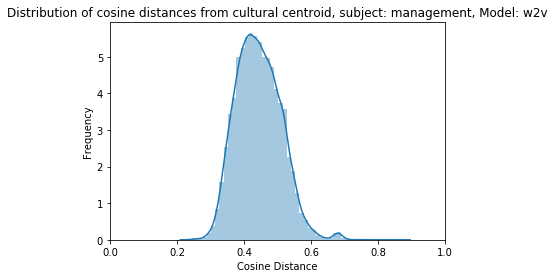

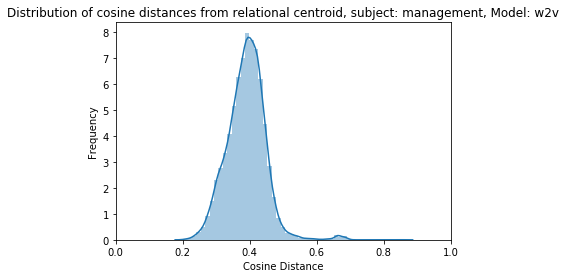

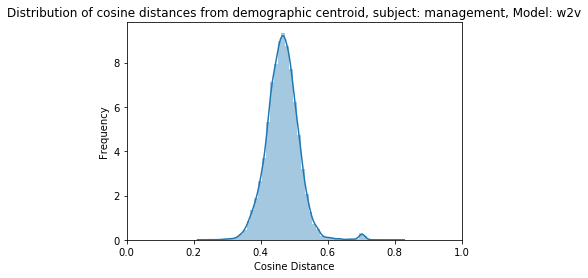

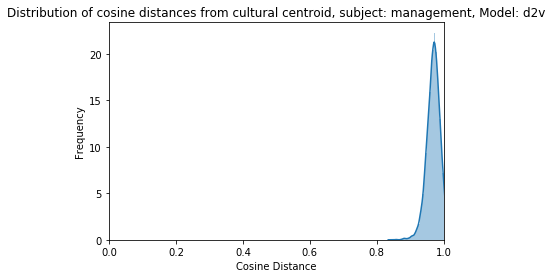

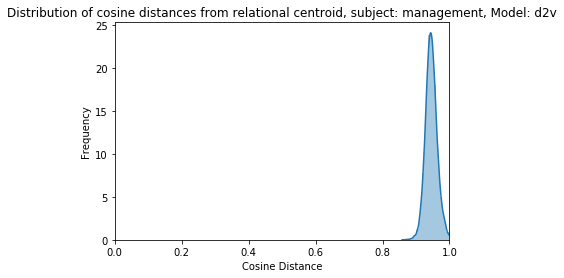

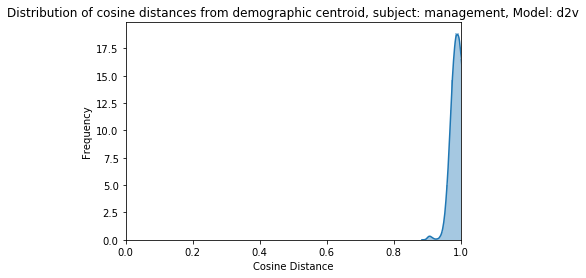

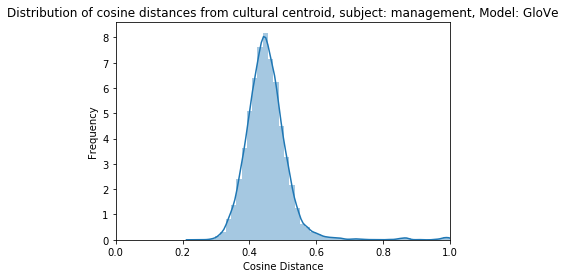

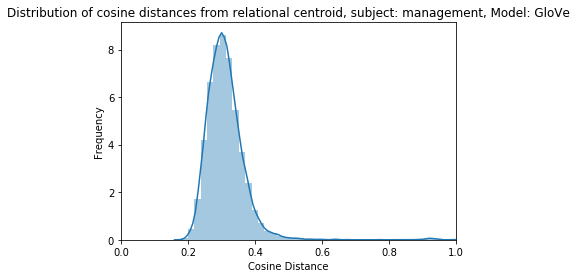

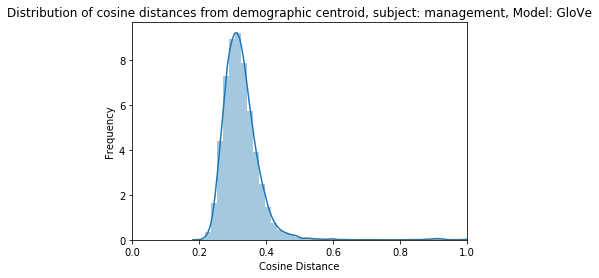

[None, None, None]

In [28]:
[plot_distribution(perspective_distances_w2v_management[i], title_template % (perspective_names[i], "management", "w2v")) for i in range(3)]
[plot_distribution(perspective_distances_d2v_management[i], title_template % (perspective_names[i], "management", "d2v")) for i in range(3)]
[plot_distribution(perspective_distances_glove_management[i], title_template % (perspective_names[i], "management", "GloVe")) for i in range(3)]

### Sociology: w2v, d2v, and GloVe

In [22]:
perspective_distances_w2v_sociology = [[distance.cosine(centroid, v) for v in sociology_df["avg_w2v"]] for centroid in perspective_centroids_w2v]
perspective_distances_d2v_sociology = [[distance.cosine(centroid, v) for v in sociology_df["avg_d2v"]] for centroid in perspective_centroids_d2v]
perspective_distances_glove_sociology = [[distance.cosine(centroid, v) for v in sociology_df["avg_glove"]] for centroid in perspective_centroids_glove]

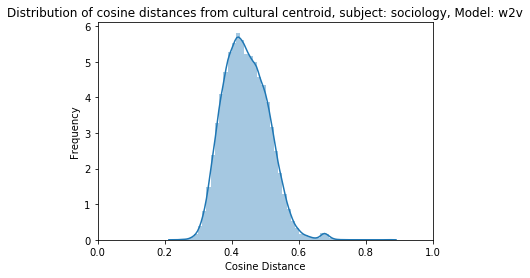

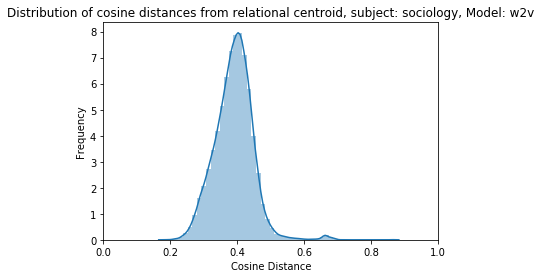

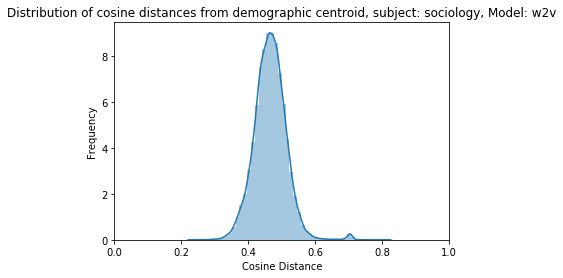

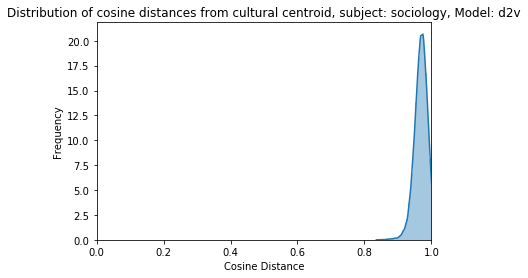

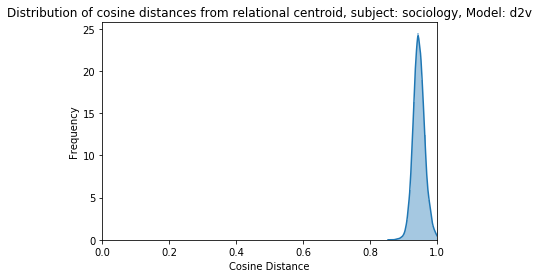

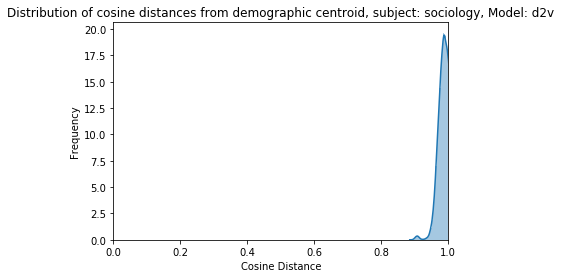

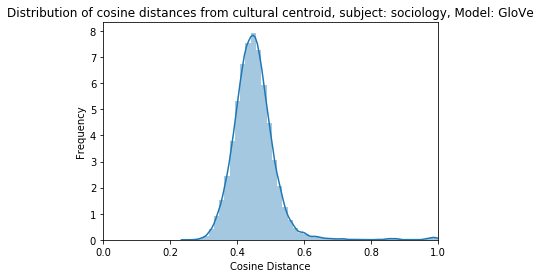

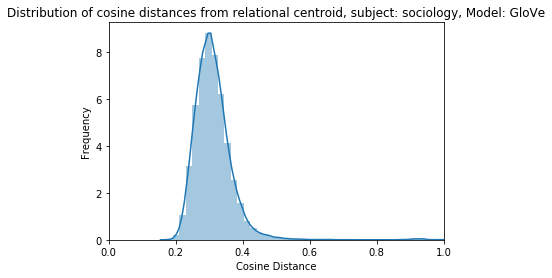

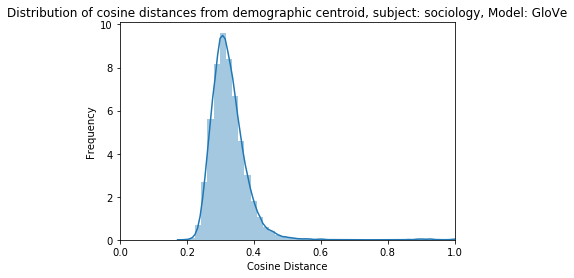

[None, None, None]

In [30]:
[plot_distribution(perspective_distances_w2v_sociology[i], title_template % (perspective_names[i], "sociology", "w2v")) for i in range(3)]
[plot_distribution(perspective_distances_d2v_sociology[i], title_template % (perspective_names[i], "sociology", "d2v")) for i in range(3)]
[plot_distribution(perspective_distances_glove_sociology[i], title_template % (perspective_names[i], "sociology", "GloVe")) for i in range(3)]

### Infersent: management, sociology

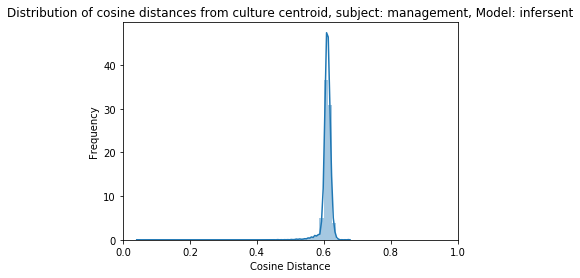

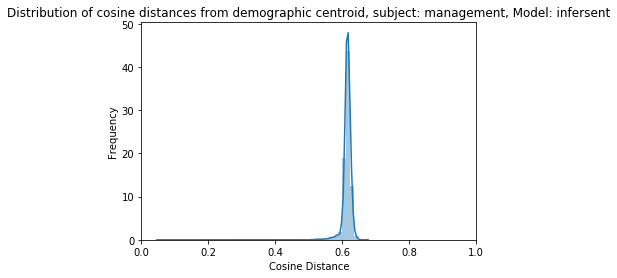

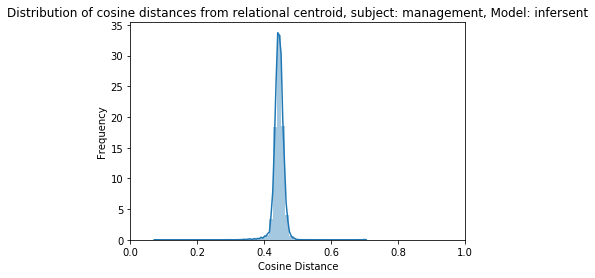

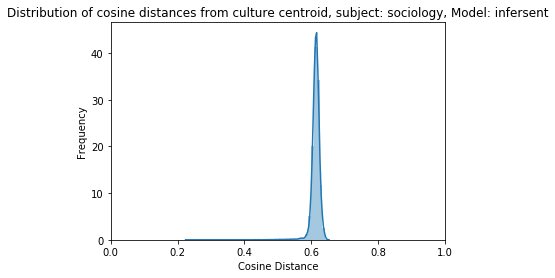

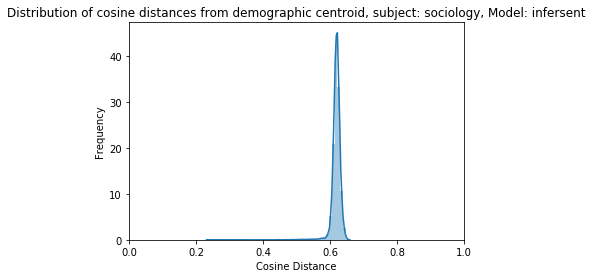

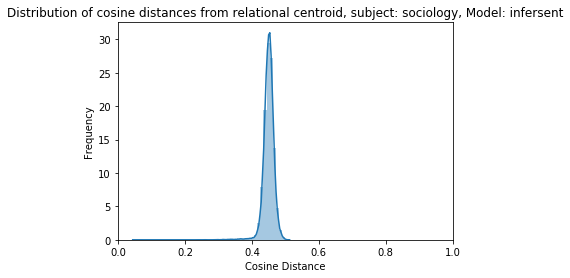

In [31]:
plot_distribution(management_df.culture, title_template % ("culture", "management", "infersent"))
plot_distribution(management_df.demographic, title_template % ("demographic", "management", "infersent"))
plot_distribution(management_df.relational, title_template % ("relational", "management", "infersent"))

plot_distribution(sociology_df.culture, title_template % ("culture", "sociology", "infersent"))
plot_distribution(sociology_df.demographic, title_template % ("demographic", "sociology", "infersent"))
plot_distribution(sociology_df.relational, title_template % ("relational", "sociology", "infersent"))

## Sample Generation

In [32]:
import random 

from bisect import bisect
from heapq import nsmallest

def k_nearest(k, center, sorted_data):
    'Return *k* members of *sorted_data* nearest to *center*'
    i = bisect([x for _,x in sorted_data], center)
    segment = sorted_data[max(i-k, 0) : i+k]
    return [i for i,_ in nsmallest(k, segment, key=lambda x: abs(x[1] - center))]

def get_all_sample_indices(data):
    arr = np.array([x for x in data if x==x])
    median = np.median(arr)
    std_dev = np.std(arr)
    sorted_data = list(enumerate(data))
    sorted_data.sort(key=lambda x: x[1])
    results = []
    
    results.append(k_nearest(10, median-(2 * std_dev), sorted_data))
    results.append(k_nearest(10, median-(std_dev), sorted_data))
    results.append(k_nearest(10, median, sorted_data))
    results.append(k_nearest(10, median+(std_dev), sorted_data))
    results.append(k_nearest(10, median+(2 * std_dev), sorted_data))
    
    return results

def sample(data):
    # 5 each
    random.seed(42)
    arr = np.array([x for x in data if x==x])
    median = np.median(arr)
    std_dev = np.std(arr)
    below = filter(lambda x: data[x] < median and data[x] > median - std_dev, range(len(data)))
    above = filter(lambda x: data[x] > median and data[x] < median + std_dev, range(len(data)))
    return random.sample(list(below), k=5), random.sample(list(above), k=5)

In [105]:
sociology_df.iloc[x]

,filename,subject,avg_w2v,avg_d2v,avg_glove,edited_filename,culture,demographic,relational
5842,journal-article-10.2307_41554554,Sociology,"[-0.027884714, 0.03612453, -0.13368726, 0.0553...","[-0.027884714, 0.03612453, -0.13368726, 0.0553...","[-0.009520808027065515, 0.09876753893162438, -...",10.2307_41554554,0.630465,0.635022,0.468647
58516,journal-article-10.2307_3088972,Sociology,"[-0.026658224, 0.005718707, -0.08743025, 0.052...","[-0.026658224, 0.005718707, -0.08743025, 0.052...","[0.0011296633514169948, 0.08327958376612804, -...",10.2307_3088972,0.610070,0.617753,0.444132
68331,journal-article-10.2307_44242618,Sociology,"[-0.019224683, 0.03941398, -0.11017949, 0.0649...","[-0.019224683, 0.03941398, -0.11017949, 0.0649...","[-0.001093350351561328, 0.06322691591317607, -...",10.2307_44242618,0.637537,0.646093,0.488395
16311,journal-article-10.2307_352278,Sociology,"[-0.024482347, 0.026685802, -0.21456885, 0.040...","[-0.024482347, 0.026685802, -0.21456885, 0.040...","[-0.12217492871239752, 0.10135351257560622, -0...",10.2307_352278,0.615860,0.621044,0.452805
48388,journal-article-10.2307_3517613,Sociology,"[-0.011056996, 0.006088221, -0.09821429, 0.067...","[-0.011056996, 0.006088221, -0.09821429, 0.067...","[-0.10454295315927502, 0.09329662036251449, -0...",10.2307_3517613,0.599590,0.607655,0.428359


In [35]:
perspective_samples_w2v_management = [get_all_sample_indices(l) for l in perspective_distances_w2v_management]
perspective_samples_d2v_management = [get_all_sample_indices(l) for l in perspective_distances_d2v_management]
perspective_samples_glove_management = [get_all_sample_indices(l) for l in perspective_distances_glove_management]
perspective_samples_w2v_sociology = [get_all_sample_indices(l) for l in perspective_distances_w2v_management]
perspective_samples_d2v_sociology = [get_all_sample_indices(l) for l in perspective_distances_d2v_management]
perspective_samples_glove_sociology = [get_all_sample_indices(l) for l in perspective_distances_glove_management]

In [39]:
for i, name in enumerate(perspective_names):
    for j, center in enumerate(["2below", "1below", "median", "1above", "2above"]):
        management_df.iloc[perspective_samples_w2v_management[i][j]].to_csv("./sample_output2/management_%s_w2v_%s.csv" % (name, center))
        management_df.iloc[perspective_samples_d2v_management[i][j]].to_csv("./sample_output2/management_%s_d2v_%s.csv" % (name, center))
        management_df.iloc[perspective_samples_glove_management[i][j]].to_csv("./sample_output2/management_%s_glove_%s.csv" % (name, center))

        sociology_df.iloc[perspective_samples_w2v_sociology[i][j]].to_csv("./sample_output2/sociology_%s_w2v_%s.csv" % (name, center))
        sociology_df.iloc[perspective_samples_d2v_sociology[i][j]].to_csv("./sample_output2/sociology_%s_d2v_%s.csv" % (name, center))
        sociology_df.iloc[perspective_samples_glove_sociology[i][j]].to_csv("./sample_output2/sociology_%s_glove_%s.csv" % (name, center))

In [40]:
samples_infersent_culture_management = get_all_sample_indices(list(management_df.culture))
samples_infersent_demographic_management = get_all_sample_indices(list(management_df.demographic))
samples_infersent_relational_management = get_all_sample_indices(list(management_df.relational))

samples_infersent_culture_sociology = get_all_sample_indices(list(sociology_df.culture))
samples_infersent_demographic_sociology = get_all_sample_indices(list(sociology_df.demographic))
samples_infersent_relational_sociology = get_all_sample_indices(list(sociology_df.relational))

In [41]:
for i, center in enumerate(["2below", "1below", "median", "1above", "2above"]):
    management_df.iloc[samples_infersent_culture_management[i]].to_csv("./sample_output/management_culture_infersent_%s.csv" % (center))
    management_df.iloc[samples_infersent_demographic_management[i]].to_csv("./sample_output/management_demographic_infersent_%s.csv" % (center))
    management_df.iloc[samples_infersent_relational_management[i]].to_csv("./sample_output/management_relational_infersent_%s.csv" % (center))

    sociology_df.iloc[samples_infersent_culture_management[i]].to_csv("./sample_output/sociology_culture_infersent_%s.csv" % (center))
    sociology_df.iloc[samples_infersent_demographic_management[i]].to_csv("./sample_output/sociology_demographic_infersent_%s.csv" % (center))
    sociology_df.iloc[samples_infersent_relational_management[i]].to_csv("./sample_output/sociology_relational_infersent_%s.csv" % (center))